## **데이터 불러오기**

In [61]:
import pandas as pd
url = 'https://ds-lecture-data.s3.ap-northeast-2.amazonaws.com/datasets/vgames2.csv'
df = pd.read_csv(url)

In [62]:
df = df.fillna(0)
df.isnull().sum()
df.drop(columns='Unnamed: 0',inplace = True)

In [63]:
df.head()

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008.0,Action,Destineer,0.04,0,0,0
1,The Munchables,Wii,2009.0,Action,Namco Bandai Games,0.17,0,0,0.01
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010.0,Adventure,Alchemist,0,0,0.02,0
3,Deal or No Deal: Special Edition,DS,2010.0,Misc,Zoo Games,0.04,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010.0,Platform,D3Publisher,0.12,0.09,0,0.04


## **데이터 전처리(지역값 단위 통일)**

단위 : 만

Type : Float

In [64]:
# '지역에 따라서 선호하는 게임 장르가 다를까'
country_sales = df.iloc[:,5:]
country_sales

,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,0.04,0,0,0
1,0.17,0,0,0.01
2,0,0,0.02,0
3,0.04,0,0,0
4,0.12,0.09,0,0.04
...,...,...,...,...
16593,0.15,0.04,0,0.01
16594,0.01,0,0,0
16595,0.44,0.19,0.03,0.13
16596,0.05,0.05,0.25,0.03


In [65]:
lst = []
def toFloat(column) :
  for i in range(len(column)) :
    data = column[i].lower()
    if data.find('k') != -1 : 
      column[i] = float(data.rstrip('k')) * 0.001
    elif data.find('m') != -1 :
      column[i] = data.rstrip('m')
  return column.astype(float)

def toCount(data) :
  return data*100
country_sales = (country_sales
                 .apply(toFloat)
                 .apply(toCount)
                 .astype(int)
)

In [66]:
country_sales.dtypes

NA_Sales       int64
EU_Sales       int64
JP_Sales       int64
Other_Sales    int64
dtype: object

## **데이터 전처리(연도)**

In [67]:
year = df['Year']
def reset_year(data) :
  if data < 1000 :
    if data == 0 : data
    elif data < 21 : data += 2000
    elif data < 100 : data += 1900
  return int(data)
year = year.apply(reset_year)

## **데이터 합치기(전처리 데이터들 종합)**

In [68]:
df['Year'] = year
df = df.drop(['NA_Sales','EU_Sales','JP_Sales','Other_Sales'],axis=1)
df = pd.concat([df, country_sales], axis=1)
df

,Name,Platform,Year,Genre,Publisher,NA_Sales,EU_Sales,JP_Sales,Other_Sales
0,Candace Kane's Candy Factory,DS,2008,Action,Destineer,4,0,0,0
1,The Munchables,Wii,2009,Action,Namco Bandai Games,17,0,0,1
2,Otome wa Oanesama Boku ni Koi Shiteru Portable,PSP,2010,Adventure,Alchemist,0,0,2,0
3,Deal or No Deal: Special Edition,DS,2010,Misc,Zoo Games,4,0,0,0
4,Ben 10 Ultimate Alien: Cosmic Destruction,PS3,2010,Platform,D3Publisher,12,9,0,4
...,...,...,...,...,...,...,...,...,...
16593,Ice Age 2: The Meltdown,GC,2006,Platform,Vivendi Games,15,4,0,1
16594,Rainbow Islands: Revolution,PSP,2005,Action,Rising Star Games,1,0,0,0
16595,NBA 2K16,PS3,2015,Sports,Take-Two Interactive,44,19,3,13
16596,Toukiden: The Age of Demons,PSV,2013,Action,Tecmo Koei,5,5,25,3


In [71]:
# 지역에 따라서 선호하는 게임 장르가 다를까 ==> 장르와 지역은 상관이 없다
# [['Genre'],['NA_Sales'],['EU_Sales'],['JP_Sales'],['Other_Sales']]
df_groupby_Genre  = (df
                     .loc[:, ['Genre', 'NA_Sales','EU_Sales','JP_Sales','Other_Sales']]
                     .groupby(by=['Genre'])
                     .sum()
                     .dropna()
)
df_groupby_Genre = df_groupby_Genre[1:].T
df_groupby_Genre

Genre,Action,Adventure,Fighting,Misc,Platform,Puzzle,Racing,Role-Playing,Shooter,Simulation,Sports,Strategy
NA_Sales,87418,10560,22307,40784,44632,12329,35702,31932,58168,18291,68014,6865
EU_Sales,52182,6405,10112,21222,20153,5072,23695,18348,31283,11330,37628,4529
JP_Sales,15778,5192,8732,10522,13063,5686,5639,34474,3826,6369,13523,4938
Other_Sales,18633,1680,3661,7403,5148,1251,7709,5696,10259,3145,13463,1136


In [70]:
from scipy.stats import chi2_contingency
df_Relation_GenreCountry = chi2_contingency(df_groupby_Genre, correction = False)
df_Relation_GenreCountry

(69642.67327891082,
 0.0,
 33,
 array([[85838.43652972, 47526.97302139, 25091.81550469, 15553.77494421],
        [11758.62911861,  6510.51057641,  3437.21722296,  2130.64308202],
        [22105.45320566, 12239.33380668,  6461.74343229,  4005.46955537],
        [39429.41578553, 21831.25480902, 11525.78805423,  7144.54135121],
        [40941.35932912, 22668.38678522, 11967.7510021 ,  7418.50288355],
        [12005.76899311,  6647.34683092,  3509.45977986,  2175.42439611],
        [35884.61111857, 19868.56952975, 10489.5904218 ,  6502.22892987],
        [44618.36656368, 24704.26990124, 13042.59335559,  8084.77017949],
        [51073.60089041, 28278.40009392, 14929.55163808,  9254.4473776 ],
        [19305.02792117, 10688.79604848,  5643.13865087,  3498.03737949],
        [65424.48557886, 36224.18914828, 19124.52262647, 11854.80264639],
        [ 8616.84496555,  4770.9694487 ,  2518.82831106,  1561.35727469]]))

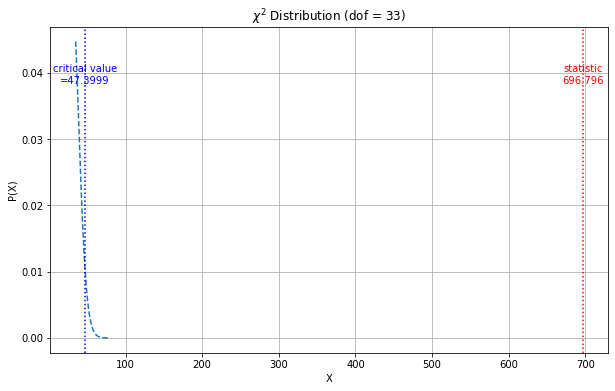

In [59]:
from numpy import linspace
from scipy.stats import chi2
import matplotlib.pyplot as plt

dof = 33          # 자유도
x = linspace(35, 80, 201)
y = chi2(dof).pdf(x)

x95 = chi2(dof).ppf(.95)
plt.figure(figsize=(10, 6))
plt.plot(x, y, '--')

plt.axvline(x=x95, color='b', linestyle=':')
plt.text(x95, 0.04, 'critical value\n=' + str(round(x95, 4)),va = 'center_baseline', ha='center', color='b')
plt.axvline(x=df_Relation_GenreCountry[0], color='r', linestyle=':')
plt.text(df_Relation_GenreCountry[0], 0.04, 'statistic\n' + str(round(df_Relation_GenreCountry[0], 4)),va = 'center_baseline', ha='center', color='r')

plt.xlabel('X')
plt.ylabel('P(X)')
plt.grid()
plt.title(r'$\chi^2$ Distribution (dof = 33)')
plt.show()

## **데이터 전처리**